<a href="https://colab.research.google.com/github/Devraj02-sys/AI-ML-project/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neattext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 9.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Random Forest Accuracy: 0.8571428571428571
XGBoost Accuracy: 0.8571428571428571


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Prediction: 2


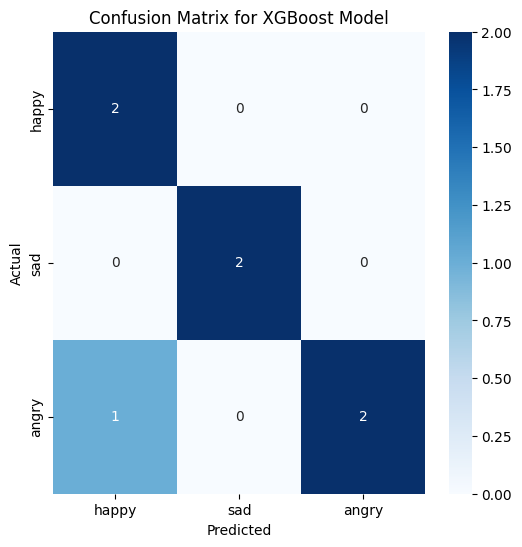

['emotion_models.pkl']

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import torch.nn.functional as F

# Load NLP Model for Word Embeddings
nlp = spacy.load("en_core_web_md")

def get_embedding(text):
    return nlp(text).vector  # Get a 300-dim vector for the text

# Extended Dataset (Further Expansion for Better Generalization)
data = [
    ("I am so happy today!", "happy"),
    ("I feel very sad and lonely.", "sad"),
    ("Why are you so angry with me?", "angry"),
    ("This is the best day of my life!", "happy"),
    ("I am extremely frustrated right now.", "angry"),
    ("Tears won't stop falling from my eyes.", "sad"),
    ("I just want to dance with joy!", "happy"),
    ("He makes me so mad!", "angry"),
    ("I feel heartbroken and lost.", "sad"),
    ("What a wonderful surprise!", "happy"),
    ("I'm feeling miserable and depressed.", "sad"),
    ("I am boiling with rage!", "angry"),
    ("Laughing all day, best time ever!", "happy"),
    ("I feel so alone and broken.", "sad"),
    ("This situation makes me furious!", "angry"),
    ("Excited for the trip tomorrow!", "happy"),
    ("I can't stop crying, I feel terrible.", "sad"),
    ("You just ruined everything, I'm so mad!", "angry"),
    ("I'm thrilled about this!", "happy"),
    ("I am devastated and hopeless.", "sad"),
    ("Everything is making me furious!", "angry"),
    ("I couldn't be happier!", "happy"),
    ("The loneliness is unbearable.", "sad"),
    ("Anger is taking over me.", "angry"),
    ("Life feels wonderful and full of joy!", "happy"),
    ("I feel so dejected and worthless.", "sad"),
    ("I am fuming with anger right now!", "angry"),
    ("My heart is filled with happiness!", "happy"),
    ("My sadness is overwhelming me.", "sad"),
    ("I'm exploding with rage!", "angry"),
    ("I feel ecstatic about my achievements!", "happy"),
    ("Why does everything always go wrong?", "sad"),
    ("I am burning with anger and frustration!", "angry")
]


# Convert text and labels
texts, labels = zip(*data)
label_map = {"happy": 0, "sad": 1, "angry": 2}
numeric_labels = [label_map[label] for label in labels]

# Convert text to embeddings
text_embeddings = np.array([get_embedding(text) for text in texts])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(text_embeddings, numeric_labels, test_size=0.2, random_state=42, stratify=numeric_labels)

# Optimize RandomForestClassifier
rf = RandomForestClassifier(n_estimators=700, max_depth=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Optimize XGBoost
xgb = XGBClassifier(n_estimators=700, learning_rate=0.01, max_depth=100)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Fine-tune BERT Model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

def predict_with_bert(text):
    inputs = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = bert_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    return torch.argmax(probs).item()

# Test BERT Prediction
print("BERT Prediction:", predict_with_bert("I feel amazing today!"))

# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

# Save Best Model
joblib.dump((rf, xgb, bert_model), "emotion_models.pkl")